In [2]:
import qutip
import numpy as np
from scipy.linalg import expm


In [3]:
!python -m pip freeze > requirements.txt

In [4]:
def build_init_state(a, b, c):
    inita = qutip.basis(2, a)
    initb = qutip.basis(2, b)
    initc = qutip.basis(2, c)
    init = qutip.tensor(inita, initb, initc)
    return init

In [5]:
# pretty print from Chao
import matplotlib.pyplot as plt


def plotMatrix(matrix, rounder=2, vmin=0, vmax=1):
    matrix = np.array(matrix)
    dim = len(matrix)
    nBits = int(np.log2(dim))
    number_label = np.arange(0, dim, 1)
    fig = plt.figure(figsize=(7, 7))
    plt.subplot(1, 1, 1)
    pm = plt.imshow(np.abs(matrix), interpolation="nearest", vmin=vmin, vmax=vmax)
    plt.xticks(number_label, [f"{n:0{nBits}b}" for n in number_label])
    plt.yticks(number_label, [f"{n:0{nBits}b}" for n in number_label])
    for (j, i), label in np.ndenumerate(matrix):
        label = np.round(label, rounder)
        plt.text(i, j, label, ha="center", va="center")
    plt.colorbar()
    plt.show()
    return pm


First,  by inspection construct a target unitary for cyclic_3 swap.

$U|a, b, c\rangle = |b,c,a\rangle$.

\begin{equation}
\begin{bmatrix}
1& 0& 0& 0& 0& 0& 0& 0\\
0& 0& 0& 0& 1& 0& 0& 0\\
0& 1& 0& 0& 0& 0& 0& 0\\
0& 0& 0& 0& 0& 1& 0& 0\\
0& 0& 1& 0& 0& 0& 0& 0\\
0& 0& 0& 0& 0& 0& 1& 0\\
0& 0& 0& 1& 0& 0& 0& 0\\
0& 0& 0& 0& 0& 0& 0& 1
\end{bmatrix}

\begin{bmatrix}
a\\
b\\
c\\
d\\
e\\
f\\
g\\
h
\end{bmatrix}
=
\begin{bmatrix}
a\\
e\\
b\\
f\\
c\\
g\\
d\\
h
\end{bmatrix}
\end{equation}

In [6]:
# def gaussian(t, u, s):
#     return (np.exp(-.5*((t-u)/s)**2))/np.sqrt(2*np.pi)

def gaussian(t, A, s):
    return A*np.exp(-(t/s)**2)

In [7]:
def build_circulator_U(
    phi_ab=0, phi_ac=0, phi_bc=np.pi / 2, g_ab=1.0, g_ac=1.0, g_bc=1.0
):
    # TODO: when sweeping phase parameters leave time-independent
    # when sweeping coupling parameters make time-dependet i.e gaussian shaped pusle
    # build raising and lowering operations
    a = qutip.operators.create(N=2)
    I2 = qutip.operators.identity(2)
    A = qutip.tensor(a, I2, I2)
    B = qutip.tensor(I2, a, I2)
    C = qutip.tensor(I2, I2, a)

    # construct circulator Hamiltonian
    H_ab = np.exp(1j * phi_ab) * A * B.dag() + np.exp(-1j * phi_ab) * A.dag() * B
    H_ac = np.exp(1j * phi_ac) * A * C.dag() + np.exp(-1j * phi_ac) * A.dag() * C
    H_bc = np.exp(1j * phi_bc) * B * C.dag() + np.exp(-1j * phi_bc) * B.dag() * C
    H = g_ab * H_ab + g_ac * H_ac + g_bc * H_bc

    # time evolution, if time dependent need to use master-equation
    # qutip.mesolve()
    # U = expm(1j*np.array(H))
    U = (1j * H).expm()
    return U

def _wrap_build_time_dependent_U(phi_ab=0, phi_ac=0, phi_bc=np.pi / 2, g_ab_A=0, g_ab_s=.1, g_ac_A=0, g_ac_s=.1, g_bc_A=0, g_bc_s=.1):
    a = qutip.operators.create(N=2)
    I2 = qutip.operators.identity(2)
    A = qutip.tensor(a, I2, I2)
    B = qutip.tensor(I2, a, I2)
    C = qutip.tensor(I2, I2, a)

    # construct circulator Hamiltonian
    H_ab = np.exp(1j * phi_ab) * A * B.dag() + np.exp(-1j * phi_ab) * A.dag() * B
    H_ac = np.exp(1j * phi_ac) * A * C.dag() + np.exp(-1j * phi_ac) * A.dag() * C
    H_bc = np.exp(1j * phi_bc) * B * C.dag() + np.exp(-1j * phi_bc) * B.dag() * C
    build_time_dependent_U = lambda t, args: gaussian(t,g_ab_A,g_ab_s) * H_ab + gaussian(t,g_ac_A,g_ac_s) * H_ac + gaussian(t,g_bc_A,g_bc_s) * H_bc
    return build_time_dependent_U

qutip.Qobj()
t_list = np.linspace(-1,1,100)

# H = qutip.QobjEvo(build_time_dependent_U, args, tlist=t_list)
# H_ab = np.exp(1j * 0) * A * B.dag() + np.exp(-1j * 0) * A.dag() * B
init = build_init_state(0, 1, 1)
build_time_dependent_U = _wrap_build_time_dependent_U()
result = qutip.mesolve(build_time_dependent_U, init, t_list)

# #construct an example initial state
# inita = qutip.basis(2, 1)
# initb = qutip.basis(2, 0)
# initc = qutip.basis(2, 0)
# init = qutip.tensor(inita, initb, initc)
# #print(init)

# U = build_circulator_U()
# #apply unitary to initial state
# new_state = U*init
# print(new_state)


# #expected
# expected = qutip.tensor(initb, initc, inita)
# print(expected.overlap(new_state))


In [8]:
result.states[-1]

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]

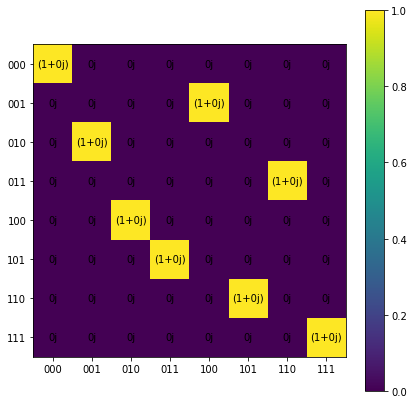

In [9]:
expected_U = qutip.Qobj(
    dims=[[2, 2, 2], [2, 2, 2]],
    inpt=(1.0 + 0j)
    * np.array(
        [
            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1],
        ]
    ),
)
# gk = [1,1,1]
# template = build_circulator_U(g_ab=gk[0], g_ac=gk[1], g_bc=gk[2])
# #1- np.abs(np.sum(np.matmul(template.full(), expected.conj().full())))/ (2*np.log2(expected.shape[0]))
# np.real(((expected_U.full() - template.full()) * (expected_U.full() - template.full()).conj()).mean() ** 0.5)
# print(expected_U)
# np.abs((expected_U*template.dag()).tr())/expected_U.shape[0]

guess_U = qutip.Qobj(
    dims=[[2, 2, 2], [2, 2, 2]],
    inpt=(1.0 + 0j)
    * np.array(
        [
            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1],
        ]
    ),
)
# plotMatrix(expected_U)
plotMatrix(guess_U)
expected_U = guess_U


#well of course this breask for 3qubit gate
# import weylchamber
# weylchamber.concurrence(*weylchamber.c1c2c3(expected_U))


In [10]:
from scipy import optimize as opt
from itertools import product

# initial guess, here I'm letting phases also be parametric
# gk = [np.random.random() for _ in range(6)]
nn= 3*np.sqrt(3)/2
gk = [np.pi/2, np.pi/2, np.pi / 2, np.pi/nn, np.pi/nn, np.pi/nn]
#gk = [0,0,np.pi/2, 1,.1,1,.1,1,.1]

In [11]:
# Option 1. Optimize inner product of quantum states
# Problem is that we want the expected inner product to be the same over all states not just 1 at a time
# construct an example initial state
# expected
# expected_state = qutip.tensor(initb, initc, inita)
init = build_init_state(0, 1, 1)
expected_state = expected_U * init
# print(expected_state)


# can we improve this by iterating over all coherent states?
def min_coherent_innerproduct(gk):
    sum = 0
    k = 0
    for a, b, c in product([0, 1], repeat=3):
        init = build_init_state(a, b, c)
        # inner_product = expected_state.overlap(
        #     build_circulator_U(
        #         phi_ab=gk[0],
        #         phi_ac=gk[1],
        #         phi_bc=gk[2],
        #         g_ab=gk[3],
        #         g_ac=gk[4],
        #         g_bc=gk[5],
        #     )
        #     * init
        # )
        build_time_dependent_U = _wrap_build_time_dependent_U(*gk)
        result = qutip.mesolve(build_time_dependent_U, init, t_list)
        inner_product = expected_state.overlap(result.states[-1])
        sum += 1 - np.real(np.conj(inner_product) * inner_product)
        k += 1
    return sum / k


# Option 2. Optmize target unitary difference
# Here I use the normalized overlap of the anstantz and target, the absolute value is taken to ignore global phase.
def min_unitary_distance(gk):
    template = build_circulator_U(
        phi_ab=gk[0], phi_ac=gk[1], phi_bc=gk[2], g_ab=gk[3], g_ac=gk[4], g_bc=gk[5]
    )
    return 1 - np.abs((expected_U.dag() * template).tr()) / expected_U.shape[0]


#opt_result = opt.minimize(fun=min_coherent_innerproduct, x0=gk)
opt_result = opt.minimize(fun=min_unitary_distance, x0=gk)
print(opt_result.fun)
print(opt_result.x)

# gk = opt_result.x
# U = build_circulator_U(g_ab=gk[0], g_ac=gk[1], g_bc=gk[2])
# from pprint import pprint
# pprint(np.matrix(U))


0.3385621722338711
[2.61799404 3.66519176 2.61799404 1.20919957 1.20919957 1.20919958]


In [12]:
print(expected_U)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [43]:
print(U.full())

[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.78867513+0.j         -0.21132487+0.j
   0.        +0.j          0.        +0.57735027j  0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.21132487+0.j          0.78867513+0.j
   0.        +0.j          0.        +0.57735027j  0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.57735027+0.j          0.        +0.j          0.        +0.57735027j
   0.        +0.57735027j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.57735027j  0.        +0.57735027j
   0.        +0.j          0.57735027+0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   

In [52]:
qutip.Qobj(U)*build_init_state(1,0,0).full()

array([[0.        +0.j],
       [0.57735027+0.j],
       [0.57735027+0.j],
       [0.        +0.j],
       [0.57735027+0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j]])

0.0


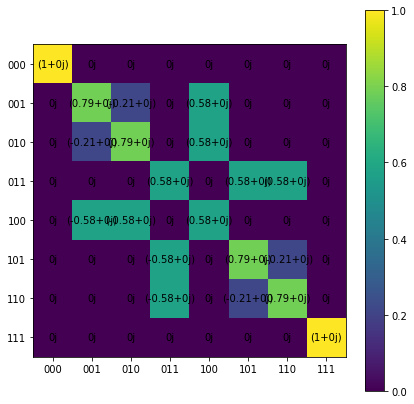

[[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.78867513+0.j -0.21132487+0.j  0.        +0.j
   0.57735027+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j -0.21132487+0.j  0.78867513+0.j  0.        +0.j
   0.57735027+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.57735027+0.j
   0.        +0.j  0.57735027+0.j  0.57735027+0.j  0.        +0.j]
 [ 0.        +0.j -0.57735027+0.j -0.57735027+0.j  0.        +0.j
   0.57735027+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -0.57735027+0.j
   0.        +0.j  0.78867513+0.j -0.21132487+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -0.57735027+0.j
   0.        +0.j -0.21132487+0.j  0.78867513+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   

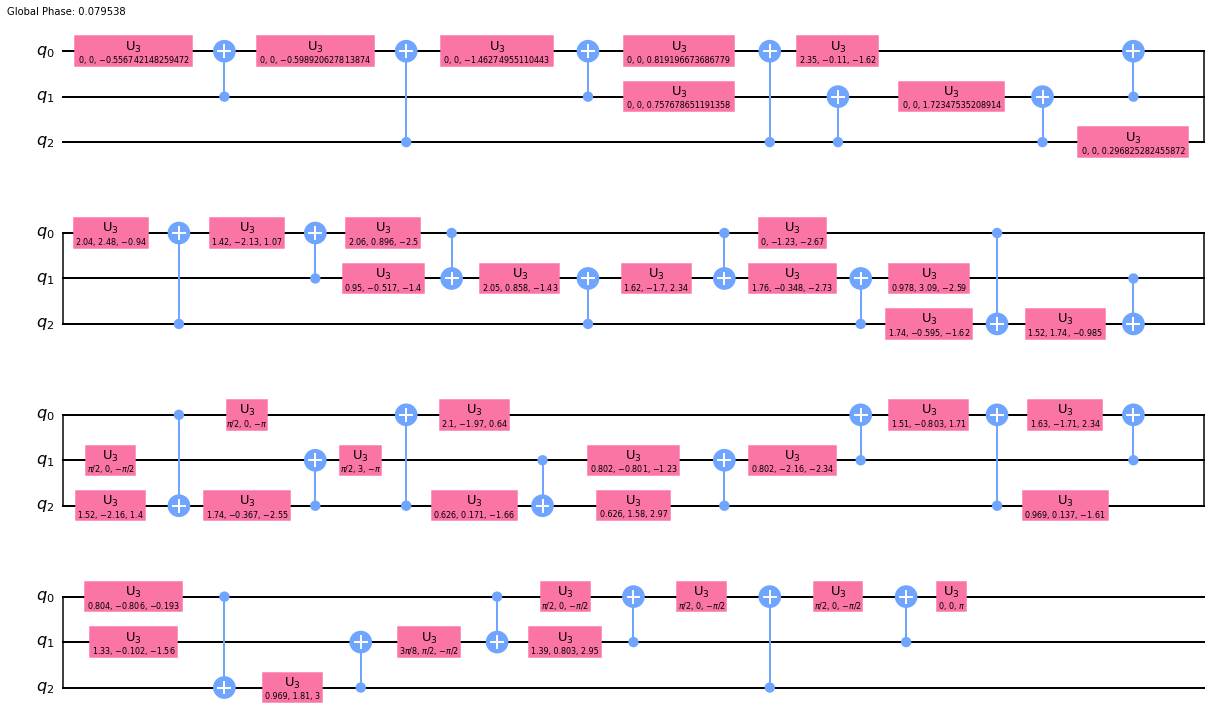

In [47]:
#U = build_circulator_U(np.pi / 2, 0, 0, np.pi / 2, 0, 0) * build_circulator_U(0, np.pi / 2, 0, 0, np.pi / 2, 0)
# U = build_circulator_U(*opt_result.x)
# plotMatrix(U)
# a = min_unitary_distance(opt_result.x)

nn= 3*np.sqrt(3)/2
params = [-np.pi/2, np.pi/2, -np.pi / 2, np.pi/nn, np.pi/nn, np.pi/nn]

# v_nn = np.sqrt(2)*np.pi/np.arccos(1/np.sqrt(3))
# params = [0,0,0, np.pi/v_nn, np.pi/v_nn, 0]
# U = build_circulator_U(*params)
from custom_gates import VSwap
U = VSwap().to_matrix()
a = min_unitary_distance(params)
print(a)
plotMatrix(U)

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
circuit = QuantumCircuit(3)
cx = Operator(U.full())
print(U.full())
circuit.unitary(cx, [0, 1,2], label='U')

from qiskit import transpile
new_circuit = transpile(circuit, basis_gates=['cx','u3','swap'], optimization_level=3)
new_circuit.draw(output='mpl')

This feels like evidence that for time-independent parameters, you just can't build the target unitary. You can get near-exact for states at a time, but if we iterate over just the most basic basis states we can't get a unitary that works for them all simultaneously. We should look into pulse control optimization methods supplied by Qutip, either GRAPE or CRAB which seem to be similar just with different optimization techniques.

https://docs.qdyn-library.net/MR-103/examples/CRAB/CRAB.html#Optimization

In [214]:
# def test_6_crab(self):
#     """
#     control.pulseoptim: Hadamard gate using CRAB algorithm
#     Apply guess and ramping pulse
#     assert that goal is achieved and fidelity error is below threshold
#     assert that starting amplitude is zero
#     """
#     # Hadamard
#     H_d = sigmaz()
#     H_c = [sigmax()]
#     U_0 = identity(2)
#     U_targ = hadamard_transform(1)

#     n_ts = 12
#     evo_time = 10

#     # Run the optimisation
#     result = cpo.opt_pulse_crab_unitary(H_d, H_c, U_0, U_targ,
#             n_ts, evo_time,
#             fid_err_targ=1e-5,
#             alg_params={'crab_pulse_params':{'randomize_coeffs':False,
#                                                 'randomize_freqs':False}},
#             init_coeff_scaling=0.5,
#             guess_pulse_type='GAUSSIAN',
#             guess_pulse_params={'variance':0.1*evo_time},
#             guess_pulse_scaling=1.0, guess_pulse_offset=1.0,
#             amp_lbound=None, amp_ubound=None,
#             ramping_pulse_type='GAUSSIAN_EDGE',
#             ramping_pulse_params={'decay_time':evo_time/100.0},
#             gen_stats=True)
#     assert_(result.goal_achieved, msg="Hadamard goal not achieved. "
#                 "Terminated due to: {}, with infidelity: {}".format(
#                 result.termination_reason, result.fid_err))
#     assert_almost_equal(result.fid_err, 0.0, decimal=3,
#                         err_msg="Hadamard infidelity too high")
#     assert_almost_equal(result.final_amps[0, 0], 0.0, decimal=3,
#                         err_msg="lead in amplitude not zero")
#     # Repeat with Qobj integration
#     result = cpo.opt_pulse_crab_unitary(H_d, H_c, U_0, U_targ,
#             n_ts, evo_time,
#             fid_err_targ=1e-5,
#             alg_params={'crab_pulse_params':{'randomize_coeffs':False,
#                                                 'randomize_freqs':False}},
#             dyn_params={'oper_dtype':Qobj},
#             init_coeff_scaling=0.5,
#             guess_pulse_type='GAUSSIAN',
#             guess_pulse_params={'variance':0.1*evo_time},
#             guess_pulse_scaling=1.0, guess_pulse_offset=1.0,
#             amp_lbound=None, amp_ubound=None,
#             ramping_pulse_type='GAUSSIAN_EDGE',
#             ramping_pulse_params={'decay_time':evo_time/100.0},
#             gen_stats=True)
#     assert_(result.goal_achieved, msg="Hadamard goal not achieved"
#                                     "(Qobj integration). "
#                 "Terminated due to: {}, with infidelity: {}".format(
#                 result.termination_reason, result.fid_err))
